# MNIST CLASSIFIER

In [13]:
# loads common libraries
import sklearn
import numpy as np
import pandas as pd

# to plot pretty figures
#%matplotlib inline
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rc("axes", labelsize=14)
mpl.rc("xtick", labelsize=12)
mpl.rc("ytick", labelsize=12)
mpl.rc("font", family="Azeret Mono", weight="bold")

In [17]:
data_train = pd.read_csv("datasets/mnist/mnist_train.csv")
data_test = pd.read_csv("datasets/mnist/mnist_test.csv")

print(f"Train {data_train.shape} \n Test {data_test.shape}")

Train (60000, 785) 
 Test (10000, 785)


In [19]:
data_train.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
# select the first 50000 for train set
X_train, y_train = data_train[:50000].drop("label", axis=1), data_train["label"][:50000]

In [21]:
# select the next 10000 for validation
X_validation, y_validation = data_train[50000:60000].drop("label", axis=1), data_train["label"][50000:60000]

# prepare test
X_test, y_test = data_test.drop("label", axis=1), data_test["label"]

## 1. Train various classifiers

In [22]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
extra_trees = ExtraTreesClassifier(n_estimators=100, random_state=42)
svm = LinearSVC(max_iter=100, tol=20, dual=True, random_state=42)
mlp = MLPClassifier(random_state=42)

estimators = [random_forest, extra_trees, svm, mlp]

for estimator in estimators:
    print("Training time", estimator)
    estimator.fit(X_train, y_train)

[estimator.score(X_validation, y_validation) for estimator in estimators]

Training time RandomForestClassifier(random_state=42)
Training time ExtraTreesClassifier(random_state=42)
Training time LinearSVC(dual=True, max_iter=100, random_state=42, tol=20)
Training time MLPClassifier(random_state=42)


[0.9736, 0.9743, 0.8662, 0.9635]

## 2. Combining the classifiers into an ensemble that outperforms them all

In [33]:
from sklearn.ensemble import VotingClassifier

named_estimators = [
    ("random forest", random_forest),
    ("extra trees", extra_trees),
    ("SVM", svm),
    ("MLP", mlp)
]

voting_classifier = VotingClassifier(named_estimators)

voting_classifier.fit(X_train, y_train)

voting_classifier.score(X_validation, y_validation)


0.975

The Voting Classifier creates a clone of each classifier and trains the clones using class indices as labels (it kind of replaces the labels for indices. So if you have labels Green, Yellow, Red, it would use indices, 0, 1, 2). To be able to retrieve the class names we use *LABEL ENCODER*.

In [34]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_validation_encoded = encoder.fit_transform(y_validation)

print(y_validation_encoded)

[3 8 6 ... 5 6 8]


In [35]:
# now we can evaluate the clones created by the Voting Classifier
# they are available under estimators_

[estimator.score(X_validation, y_validation_encoded) for estimator in voting_classifier.estimators_]

[0.9736, 0.9743, 0.8662, 0.9635]

In [36]:
# let's drop one of the estimators to see if the performance improves
voting_classifier.set_params(SVM="drop")

VotingClassifier(estimators=[('random forest',
                              RandomForestClassifier(random_state=42)),
                             ('extra trees',
                              ExtraTreesClassifier(random_state=42)),
                             ('SVM', 'drop'),
                             ('MLP', MLPClassifier(random_state=42))])

In [37]:
# the updated list of parameters
voting_classifier.estimators

[('random forest', RandomForestClassifier(random_state=42)),
 ('extra trees', ExtraTreesClassifier(random_state=42)),
 ('SVM', 'drop'),
 ('MLP', MLPClassifier(random_state=42))]

In [38]:
# to get the score without the SVM you need to either refit the model or
# remove SVM from estimators_ and names_estimators

svm_to_be_removed = voting_classifier.named_estimators_.pop("SVM")
voting_classifier.estimators_.remove(svm_to_be_removed) 

# now we evaluate the voting classifier again

voting_classifier.score(X_validation, y_validation)

0.976

In [40]:
# we can also try soft and hard voting without the need to retrain the classifier
# the default is "hard", so we try here soft
voting_classifier.voting = "soft"
voting_classifier.score(X_validation, y_validation)

0.9702

We see the performance was better with "hard" voting and without the SVM. Now we can move on and apply the best estimator on the test set.

In [41]:
voting_classifier.voting = "hard"
voting_classifier.score(X_test, y_test)

0.9732

In [42]:
# lets see how the ensemble model compares to the individual models

# first we need to create the label encoder for y_test
y_test_encoded = encoder.fit_transform(y_test)
[estimator.score(X_test, y_test_encoded) for estimator in voting_classifier.estimators_]

[0.968, 0.9703, 0.9653]

The ensemble model outperforms all the models here too!

## 3. Creating a Bagging Classifier

In [45]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bagging_classifier = BaggingClassifier(
    RandomForestClassifier(), n_estimators=200,
    random_state=42, n_jobs=-1, # if you change boostrap=False then you have Pasting, and not longer Bagging
    oob_score= True # if you set this to true, you can use the score of "out of bag" as an evaluation, since these instances were not used to train the model
)

bagging_classifier.fit(X_train, y_train)


# if you set oob_score=True you can get the score with
bagging_classifier.oob_score_
# you can also check the decision function


In [49]:
bagging_classifier.score(X_test, y_test)

0.9676

## 4. Creating a Stacking Classifier (blender)

In [46]:
from sklearn.ensemble import StackingClassifier

# since the Stacking Classifier uses k-fold validation, it doesn't need a validation set
# we can join the X_train and X_validation

X_train_all, y_train_all = data_train.drop("label", axis=1), data_train["label"]

In [47]:
stacking_classifier = StackingClassifier(
    named_estimators, # we defined this in step 2
    final_estimator = RandomForestClassifier(n_estimators=200, oob_score=True,
                                            random_state=42),
                                            n_jobs=-1)

stacking_classifier.fit(X_train_all, y_train_all)

StackingClassifier(estimators=[('random forest',
                                RandomForestClassifier(random_state=42)),
                               ('extra trees',
                                ExtraTreesClassifier(random_state=42)),
                               ('SVM',
                                LinearSVC(dual=True, max_iter=100,
                                          random_state=42, tol=20)),
                               ('MLP', MLPClassifier(random_state=42))],
                   final_estimator=RandomForestClassifier(n_estimators=200,
                                                          oob_score=True,
                                                          random_state=42),
                   n_jobs=-1)

In [48]:
stacking_classifier.score(X_test, y_test)

0.9797

## 5. Dimensionality reduction

First we will evaluate how long it takes to train a RandomForestClassifier with and without dimensionality reduction.

In [50]:
random_forest = RandomForestClassifier(n_estimators= 300, random_state=42)

X_train, y_train = data_train.drop("label", axis=1), data_train["label"]

%time random_forest.fit(X_train, y_train)

CPU times: user 1min 41s, sys: 368 ms, total: 1min 42s
Wall time: 1min 42s


RandomForestClassifier(n_estimators=300, random_state=42)

In [52]:
from sklearn.metrics import accuracy_score

y_pred = random_forest.predict(X_test)
print(f"Accuracy score - all features: {accuracy_score(y_test, y_pred):.3f}")

Accuracy score - all features: 0.972


In [53]:
# now we will reduce the features with PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95) #uses as many features as needs to have 95% of data
X_train_reduced = pca.fit_transform(X_train)

# now check how long it takes to train the same model with the reduced set
random_forest_pca = RandomForestClassifier(n_estimators=300, random_state=42)

%time random_forest_pca.fit(X_train_reduced, y_train)

CPU times: user 4min 37s, sys: 710 ms, total: 4min 37s
Wall time: 4min 39s


RandomForestClassifier(n_estimators=300, random_state=42)

In [54]:
# since we applied the transformation in X_train, we also need to apply it in X_test

X_test_reduced = pca.transform(X_test)

y_pred_pca = random_forest_pca.predict(X_test_reduced)
print(f"Accuracy Score - PCA: {accuracy_score(y_pred_pca, y_test):.3f}")

Accuracy Score - PCA: 0.951


So here PCA didn't help with processing time or accuracy score. It all depends on the dataset!
Let's try another model.

In [56]:
from sklearn.linear_model import SGDClassifier

sgd_classifier = SGDClassifier(random_state=42)
%time sgd_classifier.fit(X_train, y_train)

y_pred = sgd_classifier.predict(X_test)

print(f"Accuracy score - all features / SGD: {accuracy_score(y_pred, y_test)}")

CPU times: user 2min 10s, sys: 355 ms, total: 2min 10s
Wall time: 2min 11s
Accuracy score - all features / SGD: 0.874


In [57]:
# now comparing with PCA
sgd_classifier_pca = SGDClassifier(random_state=42)

%time sgd_classifier_pca.fit(X_train_reduced, y_train)

y_pred = sgd_classifier_pca.predict(X_test_reduced)

print(f"Accuracy score - SGD with PCA: {accuracy_score(y_test, y_pred)}")

CPU times: user 32.7 s, sys: 41.6 ms, total: 32.8 s
Wall time: 32.9 s
Accuracy score - SGD with PCA: 0.8959


So here we see that PCA can improve performance when using SGD, although in this case SGA performs worse than RandomForest.
**So the decision to use PCA or not depends on the dataset!!**

## 6.0 Dimensionality reduction for visualisation

Exercise: Use t-SNE to reduce the first 5,000 images of the MNIST dataset down to two dimensions and plot the result using Matplotlib. You can use a scatterplot using 10 different colors to represent each image's target class.

In [58]:
# to speed things up we will use only the first 5000 instances of the training set
X_sample, y_sample = data_train[:5000].drop("label", axis=1), data_train["label"][:5000]

In [59]:
# use t-SNE to reduce dimensionality to 2D so we can plot the dataset
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, learning_rate="auto", random_state=42)

%time X_reduced = tsne.fit_transform(X_sample)

CPU times: user 1min 39s, sys: 5.23 s, total: 1min 44s
Wall time: 11.9 s


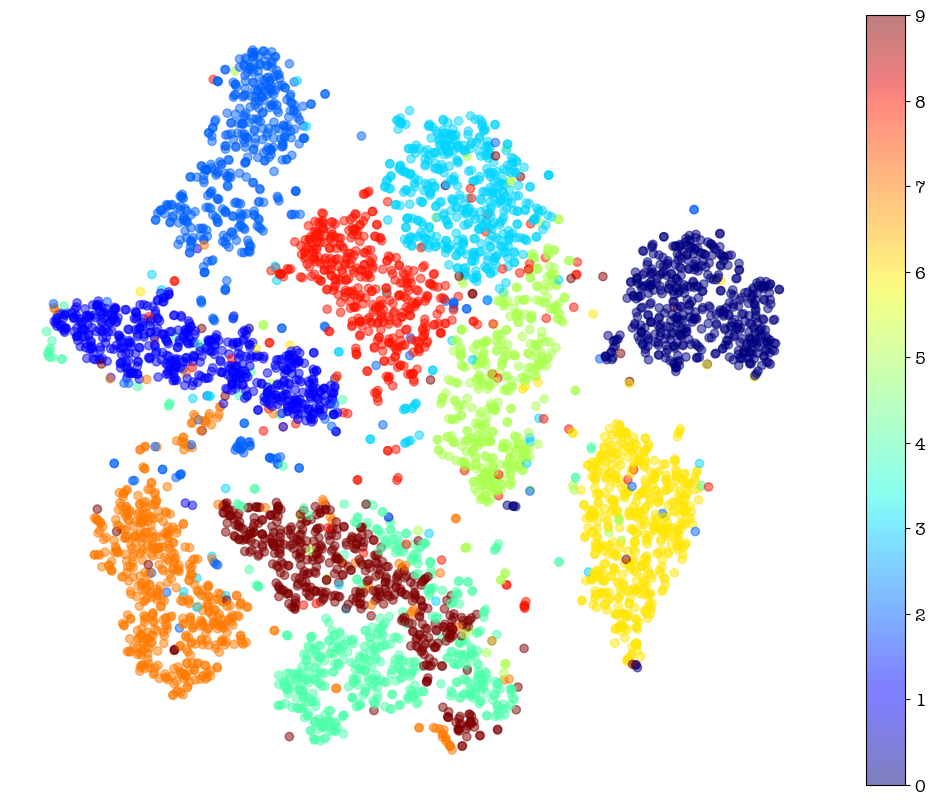

In [65]:
# now we will use Matplotlib to plot a scatterplot using a different color for each digit
import matplotlib.pyplot as plt

font = {"family": "American Typewriter",
"weight": "bold",
"size": 14}

plt.rcParams.update({"font.family": font["family"], "font.weight": font["weight"], "font.size": font["size"]})

plt.figure(figsize=(13, 10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1],
            c=y_sample.astype(np.int8), cmap="jet", alpha=0.5)
plt.axis('off')
plt.colorbar()
plt.show()